In [43]:
import sys
sys.path.append('./../')
from src import proyecto_1
from src.pipelines import modeling
from src.utils import utils
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
proyecto_1.main()

./../src/pipelines/feature_engineering.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [3]:
modeling.modeling('output/fe_df.pkl')

/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [4]:
c5_evaluation = utils.load_df('output/model_loop.pkl')

In [5]:
c5_train = utils.load_df('output/fe_df.pkl')
c5_test = utils.load_df('output/test.pkl')

In [6]:
c5_test_ = c5_test.copy()
c5_train_ = c5_train.copy()
c5_train_ = c5_train_.drop('label',axis=1)
names=np.array(c5_test_.dia_semana.unique())
names=np.append(names,np.array(c5_test_.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_test_.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_test_.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))   
#Definicion de transformers
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
    ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
    ('mes', SimpleImputer(strategy="mean"), ['mes']),
    ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
    ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
col_trans.fit(c5_test_)
df_input_vars = col_trans.transform(c5_test_)
X = df_input_vars
y = c5_test.label.values.reshape(df_input_vars.shape[0],)

In [7]:
X_test = pd.DataFrame.sparse.from_spmatrix(X)
X_test.columns = names
X_test
selection_test = list(c5_train_.columns)
selection_test
X_test_ = X_test[selection_test]
prediction= (c5_evaluation[1].predict_proba(X_test_)[:,1] >= 0.2551).astype(bool)
proba = c5_evaluation[1].predict_proba(X_test_)

## ROC

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

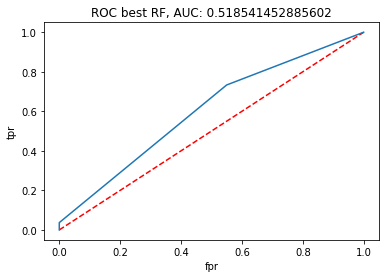

In [9]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y, proba[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y, prediction)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusion

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, prediction)

array([[219986,      0],
       [ 54426,   2096]])

## Accuracy

In [11]:

from sklearn.metrics import accuracy_score

accuracy_score(y, prediction)

0.8031666353233903

In [12]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y, proba[:,1], pos_label=1)

In [13]:
thresholds_2 = np.append(thresholds_2, 1)

In [14]:
(precision.shape, recall.shape, thresholds_2.shape)

((5,), (5,), (5,))

### Reporte de metricas

In [15]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [16]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.170758,0.204414,1.000000,0.339441,1.000000,1.000000,0.000000,0.000000
1,0.183245,0.255171,0.733166,0.378581,0.733166,0.549858,0.450142,0.266834
2,0.222305,0.944223,0.037738,0.072574,0.037738,0.000573,0.999427,0.962262
3,0.584369,1.000000,0.037083,0.071514,0.037083,0.000000,1.000000,0.962917


In [ ]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)


In [ ]:
def recall_at_k(y_true, y_scores, k):
   threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
   y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

   return metrics.recall_score(y_true, y_pred)

In [ ]:
def get_top_k(y,y_scores,k):
    array=np.stack((y, y_scores), axis=-1)
    ordena_k = array[np.argsort(array[:, 1])[::-1]]
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top[:,[0]],top[:,[1]]

In [ ]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k_y,top_k_proba = get_top_k(y_true,y_scores, k)
        #d['precision'] = precision_at_k(top_k_y,top_k_proba,k)
        #d['recall'] = recall_at_k(top_k_y,top_k_proba,k)
        d['precision'] = precision_at_k(y_true, y_scores,k)
        d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    #ax1.plot([k,k],[1,0], 'k--', c='red')
    plt.legend()

    #if save_target is not None:
    #    plt.savefig(save_target)

    return pr_k

In [ ]:
pr_k_curve(y, proba[:,1],0)

## Aequitas

In [75]:
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
#from aequitas.preprocessing import preprocess_input_df

In [125]:
c5_aeq = pd.DataFrame({'score':prediction, 'label_value': y, 'delegacion': c5_test['delegacion_inicio']})

In [126]:
c5_aeq['delegacion'] = c5_aeq['delegacion'].astype(str)

In [114]:
c5_aeq.tail()

,score,label_value,delegacion
1247592,0,0,TLALPAN
1141190,0,0,COYOACAN
316616,0,0,IZTACALCO
922952,0,1,GUSTAVO A. MADERO
812603,0,0,COYOACAN


In [115]:
c5_aeq.delegacion.count()

276508

In [116]:
c5_aeq.delegacion.unique()

array(['MIGUEL HIDALGO', 'GUSTAVO A. MADERO', 'CUAJIMALPA', 'CUAUHTEMOC',
       'XOCHIMILCO', 'VENUSTIANO CARRANZA', 'IZTACALCO', 'TLALPAN',
       'IZTAPALAPA', 'AZCAPOTZALCO', 'COYOACAN', 'TLAHUAC',
       'BENITO JUAREZ', 'ALVARO OBREGON', 'MAGDALENA CONTRERAS',
       'MILPA ALTA'], dtype=object)

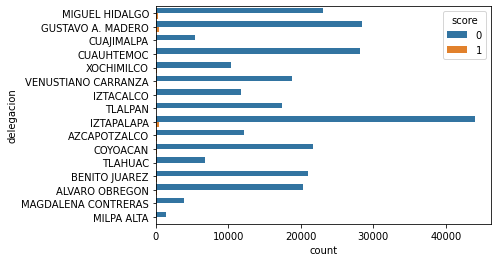

In [117]:
by_delegacion = sns.countplot(y="delegacion", hue="score", data=c5_aeq)

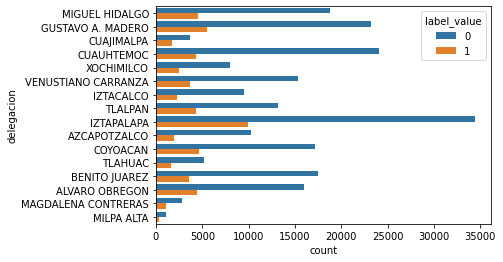

In [118]:
by_delegacion = sns.countplot(y="delegacion", hue="label_value", data=c5_aeq)

In [119]:
c5_aeq.dtypes

score           int64
label_value     int64
delegacion     object
dtype: object

In [127]:
g = Group()
xtab, attrbs = g.get_crosstabs(c5_aeq)

model_id, score_thresholds 0 {'rank_abs': [2096]}


In [128]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,2096,delegacion,ALVARO OBREGON,0.037921,1.0,0.212967,0.0,0.0,...,0.008324,0,4313,15939,170,4483,15939,20422,276508,0.219518
1,0,binary 0/1,2096,delegacion,AZCAPOTZALCO,0.040061,1.0,0.155854,0.0,0.0,...,0.006462,0,1893,10253,79,1972,10253,12225,276508,0.161309
2,0,binary 0/1,2096,delegacion,BENITO JUAREZ,0.021164,1.0,0.167493,0.0,0.0,...,0.003608,0,3515,17471,76,3591,17471,21062,276508,0.170497
3,0,binary 0/1,2096,delegacion,COYOACAN,0.025690,1.0,0.209357,0.0,0.0,...,0.005490,0,4551,17187,120,4671,17187,21858,276508,0.213698
4,0,binary 0/1,2096,delegacion,CUAJIMALPA,0.014318,1.0,0.320604,0.0,0.0,...,0.004636,0,1721,3647,25,1746,3647,5393,276508,0.323753
5,0,binary 0/1,2096,delegacion,CUAUHTEMOC,0.038686,1.0,0.146474,0.0,0.0,...,0.005860,0,4125,24037,166,4291,24037,28328,276508,0.151476
6,0,binary 0/1,2096,delegacion,GUSTAVO A. MADERO,0.076535,1.0,0.180716,0.0,0.0,...,0.014756,0,5128,23248,425,5553,23248,28801,276508,0.192806
7,0,binary 0/1,2096,delegacion,IZTACALCO,0.018777,1.0,0.191234,0.0,0.0,...,0.003646,0,2247,9503,43,2290,9503,11793,276508,0.194183
8,0,binary 0/1,2096,delegacion,IZTAPALAPA,0.036188,1.0,0.217914,0.0,0.0,...,0.008116,0,9588,34411,360,9948,34411,44359,276508,0.224261
9,0,binary 0/1,2096,delegacion,MAGDALENA CONTRERAS,0.012127,1.0,0.269878,0.0,0.0,...,0.003302,0,1059,2865,13,1072,2865,3937,276508,0.272289


In [122]:
attrbs

Index(['delegacion'], dtype='object')

In [129]:
absolute_metrics = g.list_absolute_metrics(xtab)

Conteos por grupo

In [130]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,2096,delegacion,ALVARO OBREGON,170,20252,0,4313,15939,170,4483,15939,20422,276508
1,0,binary 0/1,2096,delegacion,AZCAPOTZALCO,79,12146,0,1893,10253,79,1972,10253,12225,276508
2,0,binary 0/1,2096,delegacion,BENITO JUAREZ,76,20986,0,3515,17471,76,3591,17471,21062,276508
3,0,binary 0/1,2096,delegacion,COYOACAN,120,21738,0,4551,17187,120,4671,17187,21858,276508
4,0,binary 0/1,2096,delegacion,CUAJIMALPA,25,5368,0,1721,3647,25,1746,3647,5393,276508
5,0,binary 0/1,2096,delegacion,CUAUHTEMOC,166,28162,0,4125,24037,166,4291,24037,28328,276508
6,0,binary 0/1,2096,delegacion,GUSTAVO A. MADERO,425,28376,0,5128,23248,425,5553,23248,28801,276508
7,0,binary 0/1,2096,delegacion,IZTACALCO,43,11750,0,2247,9503,43,2290,9503,11793,276508
8,0,binary 0/1,2096,delegacion,IZTAPALAPA,360,43999,0,9588,34411,360,9948,34411,44359,276508
9,0,binary 0/1,2096,delegacion,MAGDALENA CONTRERAS,13,3924,0,1059,2865,13,1072,2865,3937,276508


Absolutos por grupo

In [131]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,ALVARO OBREGON,0.04,1.0,0.21,0.0,0.0,0.96,0.79,1.0,0.08,0.01,0.22
1,delegacion,AZCAPOTZALCO,0.04,1.0,0.16,0.0,0.0,0.96,0.84,1.0,0.04,0.01,0.16
2,delegacion,BENITO JUAREZ,0.02,1.0,0.17,0.0,0.0,0.98,0.83,1.0,0.04,0.00,0.17
3,delegacion,COYOACAN,0.03,1.0,0.21,0.0,0.0,0.97,0.79,1.0,0.06,0.01,0.21
4,delegacion,CUAJIMALPA,0.01,1.0,0.32,0.0,0.0,0.99,0.68,1.0,0.01,0.00,0.32
5,delegacion,CUAUHTEMOC,0.04,1.0,0.15,0.0,0.0,0.96,0.85,1.0,0.08,0.01,0.15
6,delegacion,GUSTAVO A. MADERO,0.08,1.0,0.18,0.0,0.0,0.92,0.82,1.0,0.20,0.01,0.19
7,delegacion,IZTACALCO,0.02,1.0,0.19,0.0,0.0,0.98,0.81,1.0,0.02,0.00,0.19
8,delegacion,IZTAPALAPA,0.04,1.0,0.22,0.0,0.0,0.96,0.78,1.0,0.17,0.01,0.22
9,delegacion,MAGDALENA CONTRERAS,0.01,1.0,0.27,0.0,0.0,0.99,0.73,1.0,0.01,0.00,0.27


Visualización de sesgo en los grupos

In [132]:
aeq = Plot()

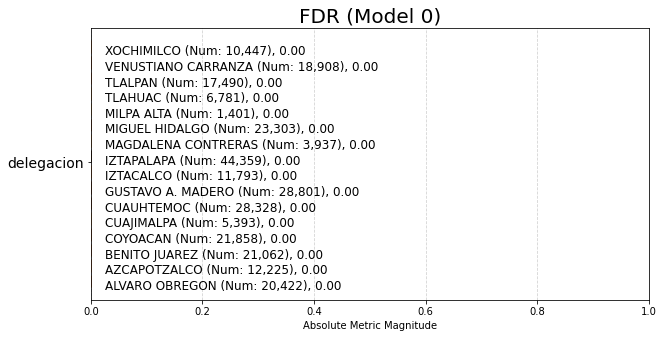

In [133]:
fdr = aeq.plot_group_metric(xtab, 'fdr')

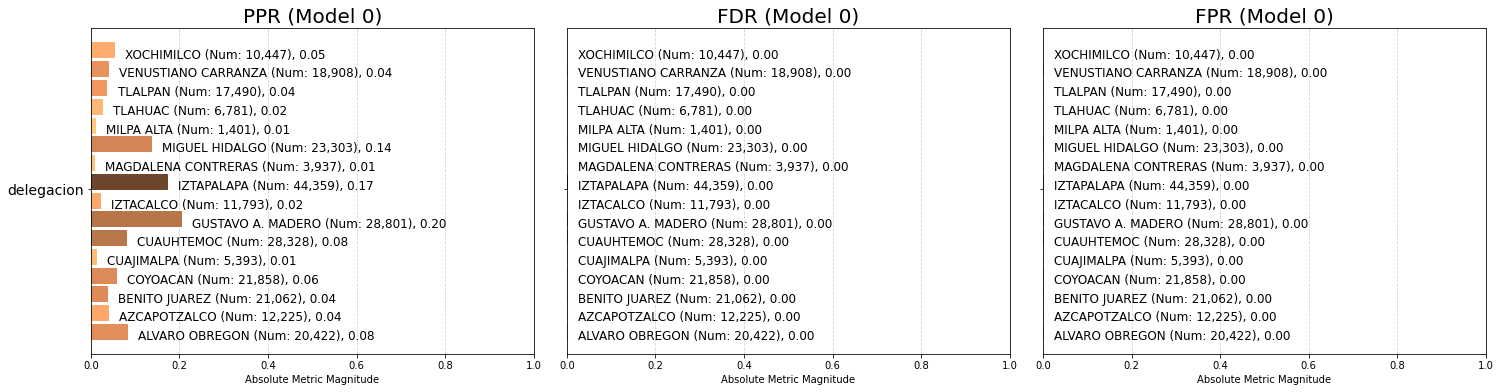

<Figure size 432x288 with 0 Axes>

In [134]:
p = aeq.plot_group_metric_all(xtab, metrics=['ppr','fdr','fpr'])

### Bias

In [135]:
bias = Bias()

In [137]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=c5_aeq, 
                                        ref_groups_dict={'delegacion':'AZCAPOTZALCO'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


In [138]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,2.15,1.29,1.0,NaN,1.37,NaN,1.00,0.95,1.0,0.93
1,delegacion,AZCAPOTZALCO,1.00,1.00,1.0,NaN,1.00,NaN,1.00,1.00,1.0,1.00
2,delegacion,BENITO JUAREZ,0.96,0.56,1.0,NaN,1.07,NaN,1.02,0.53,1.0,0.99
3,delegacion,COYOACAN,1.52,0.85,1.0,NaN,1.34,NaN,1.01,0.64,1.0,0.94
4,delegacion,CUAJIMALPA,0.32,0.72,1.0,NaN,2.06,NaN,1.03,0.36,1.0,0.80
5,delegacion,CUAUHTEMOC,2.10,0.91,1.0,NaN,0.94,NaN,1.00,0.97,1.0,1.01
6,delegacion,GUSTAVO A. MADERO,5.38,2.28,1.0,NaN,1.16,NaN,0.96,1.91,1.0,0.97
7,delegacion,IZTACALCO,0.54,0.56,1.0,NaN,1.23,NaN,1.02,0.47,1.0,0.96
8,delegacion,IZTAPALAPA,4.56,1.26,1.0,NaN,1.40,NaN,1.00,0.90,1.0,0.93
9,delegacion,MAGDALENA CONTRERAS,0.16,0.51,1.0,NaN,1.73,NaN,1.03,0.30,1.0,0.86


In [140]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=c5_aeq)

get_disparity_major_group()


In [141]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.47,1.03,1.0,NaN,0.98,NaN,1.00,1.05,1.0,1.01
1,delegacion,AZCAPOTZALCO,0.22,0.80,1.0,NaN,0.72,NaN,1.00,1.11,1.0,1.08
2,delegacion,BENITO JUAREZ,0.21,0.44,1.0,NaN,0.77,NaN,1.02,0.58,1.0,1.06
3,delegacion,COYOACAN,0.33,0.68,1.0,NaN,0.96,NaN,1.01,0.71,1.0,1.01
4,delegacion,CUAJIMALPA,0.07,0.57,1.0,NaN,1.47,NaN,1.02,0.40,1.0,0.87
5,delegacion,CUAUHTEMOC,0.46,0.72,1.0,NaN,0.67,NaN,1.00,1.07,1.0,1.09
6,delegacion,GUSTAVO A. MADERO,1.18,1.82,1.0,NaN,0.83,NaN,0.96,2.11,1.0,1.05
7,delegacion,IZTACALCO,0.12,0.45,1.0,NaN,0.88,NaN,1.02,0.52,1.0,1.03
8,delegacion,IZTAPALAPA,1.00,1.00,1.0,NaN,1.00,NaN,1.00,1.00,1.0,1.00
9,delegacion,MAGDALENA CONTRERAS,0.04,0.41,1.0,NaN,1.24,NaN,1.02,0.34,1.0,0.93


In [142]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=c5_aeq)

get_disparity_min_metric()


In [143]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,13.08,2.52,1.0,NaN,1.45,NaN,1.04,3.13,1.0,1.16
1,delegacion,AZCAPOTZALCO,6.08,1.96,1.0,NaN,1.06,NaN,1.04,3.30,1.0,1.24
2,delegacion,BENITO JUAREZ,5.85,1.09,1.0,NaN,1.14,NaN,1.06,1.75,1.0,1.23
3,delegacion,COYOACAN,9.23,1.66,1.0,NaN,1.43,NaN,1.06,2.12,1.0,1.16
4,delegacion,CUAJIMALPA,1.92,1.40,1.0,NaN,2.19,NaN,1.07,1.18,1.0,1.00
5,delegacion,CUAUHTEMOC,12.77,1.77,1.0,NaN,1.00,NaN,1.04,3.19,1.0,1.26
6,delegacion,GUSTAVO A. MADERO,32.69,4.47,1.0,NaN,1.23,NaN,1.00,6.31,1.0,1.21
7,delegacion,IZTACALCO,3.31,1.10,1.0,NaN,1.31,NaN,1.06,1.55,1.0,1.19
8,delegacion,IZTAPALAPA,27.69,2.46,1.0,NaN,1.49,NaN,1.04,2.98,1.0,1.15
9,delegacion,MAGDALENA CONTRERAS,1.00,1.00,1.0,NaN,1.84,NaN,1.07,1.00,1.0,1.07


Visualización de disparidades

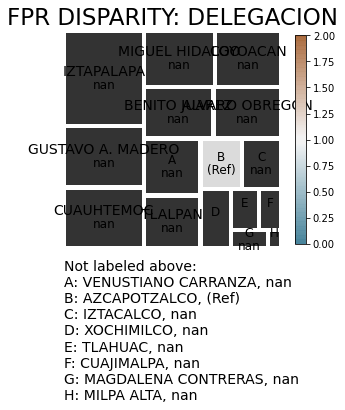

In [146]:
fpr_disparity = aeq.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='delegacion', 
                                   significance_alpha=0.05)

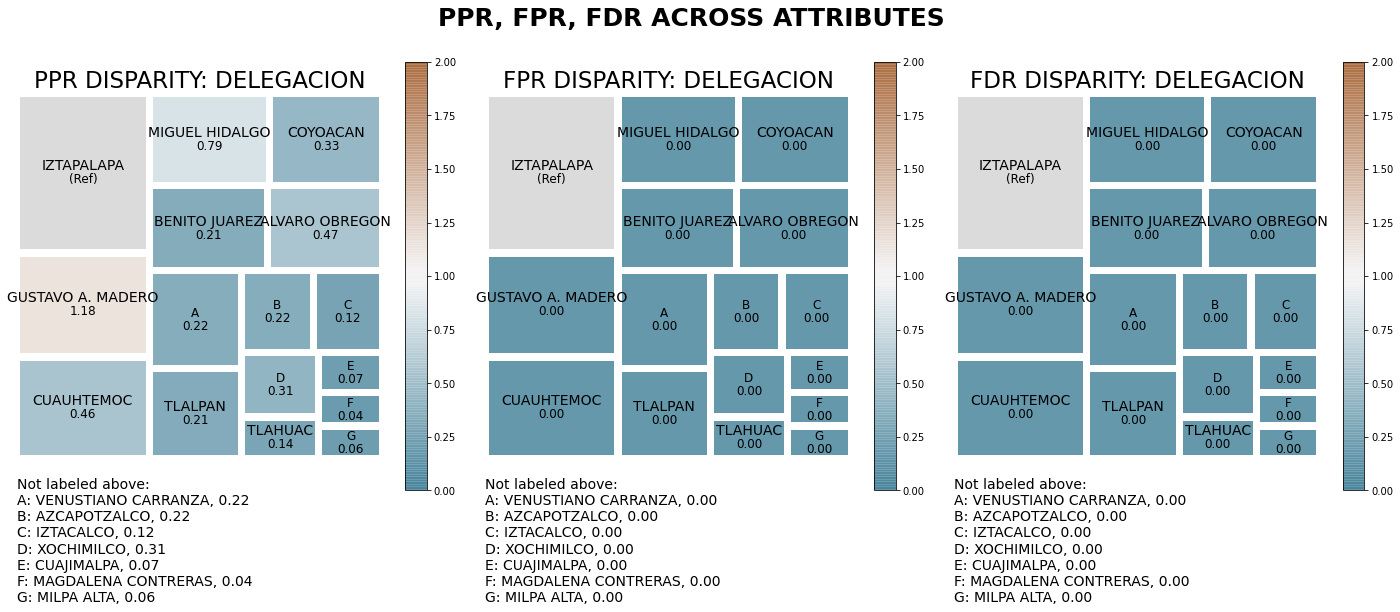

In [147]:
p = aeq.plot_disparity_all(majority_bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

### Fairness

In [148]:
fair = Fairness()

In [149]:
fdf = fair.get_group_value_fairness(bdf)

In [150]:
parity_determinations = fair.list_parities(fdf)

In [151]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Supervised Fairness,Equalized Odds,FPR Parity,TypeII Parity,FNR Parity,TypeI Parity,TPR Parity,Precision Parity,Statistical Parity,NPV Parity
0,delegacion,ALVARO OBREGON,0.04,1.0,0.21,0.0,0.0,0.96,0.79,1.0,...,False,False,NaN,False,True,NaN,True,True,False,True
1,delegacion,AZCAPOTZALCO,0.04,1.0,0.16,0.0,0.0,0.96,0.84,1.0,...,False,False,NaN,True,True,NaN,True,True,True,True
2,delegacion,BENITO JUAREZ,0.02,1.0,0.17,0.0,0.0,0.98,0.83,1.0,...,False,False,NaN,True,True,NaN,False,True,True,True
3,delegacion,COYOACAN,0.03,1.0,0.21,0.0,0.0,0.97,0.79,1.0,...,False,False,NaN,False,True,NaN,False,True,False,True
4,delegacion,CUAJIMALPA,0.01,1.0,0.32,0.0,0.0,0.99,0.68,1.0,...,False,False,NaN,False,True,NaN,False,True,False,True
5,delegacion,CUAUHTEMOC,0.04,1.0,0.15,0.0,0.0,0.96,0.85,1.0,...,False,False,NaN,True,True,NaN,True,True,False,True
6,delegacion,GUSTAVO A. MADERO,0.08,1.0,0.18,0.0,0.0,0.92,0.82,1.0,...,False,False,NaN,True,True,NaN,False,True,False,True
7,delegacion,IZTACALCO,0.02,1.0,0.19,0.0,0.0,0.98,0.81,1.0,...,False,False,NaN,True,True,NaN,False,True,False,True
8,delegacion,IZTAPALAPA,0.04,1.0,0.22,0.0,0.0,0.96,0.78,1.0,...,False,False,NaN,False,True,NaN,True,True,False,True
9,delegacion,MAGDALENA CONTRERAS,0.01,1.0,0.27,0.0,0.0,0.99,0.73,1.0,...,False,False,NaN,False,True,NaN,False,True,False,True


In [152]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,False,NaN,NaN,False,True,False,True,True,True,NaN,False,False,False,False


In [153]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,2096,delegacion,ALVARO OBREGON,0.037921,1.0,0.212967,0.0,0.0,...,True,True,True,True,True,NaN,False,False,False,False
1,0,binary 0/1,2096,delegacion,AZCAPOTZALCO,0.040061,1.0,0.155854,0.0,0.0,...,True,True,True,True,True,NaN,True,False,True,False
2,0,binary 0/1,2096,delegacion,BENITO JUAREZ,0.021164,1.0,0.167493,0.0,0.0,...,True,False,True,True,True,NaN,True,False,False,False
3,0,binary 0/1,2096,delegacion,COYOACAN,0.025690,1.0,0.209357,0.0,0.0,...,True,False,True,True,True,NaN,False,False,False,False
4,0,binary 0/1,2096,delegacion,CUAJIMALPA,0.014318,1.0,0.320604,0.0,0.0,...,True,False,True,True,True,NaN,False,False,False,False
5,0,binary 0/1,2096,delegacion,CUAUHTEMOC,0.038686,1.0,0.146474,0.0,0.0,...,True,True,True,True,True,NaN,True,False,False,False
6,0,binary 0/1,2096,delegacion,GUSTAVO A. MADERO,0.076535,1.0,0.180716,0.0,0.0,...,True,False,True,True,True,NaN,True,False,False,False
7,0,binary 0/1,2096,delegacion,IZTACALCO,0.018777,1.0,0.191234,0.0,0.0,...,True,False,True,True,True,NaN,True,False,False,False
8,0,binary 0/1,2096,delegacion,IZTAPALAPA,0.036188,1.0,0.217914,0.0,0.0,...,True,True,True,True,True,NaN,False,False,False,False
9,0,binary 0/1,2096,delegacion,MAGDALENA CONTRERAS,0.012127,1.0,0.269878,0.0,0.0,...,True,False,True,True,True,NaN,False,False,False,False


In [154]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

Visualización de equidad

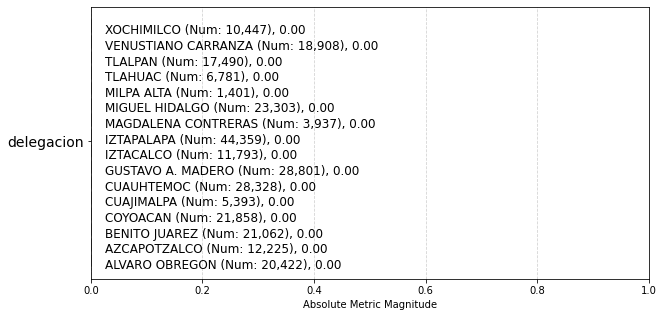

In [155]:
z = aeq.plot_fairness_group(fdf, group_metric='fpr')

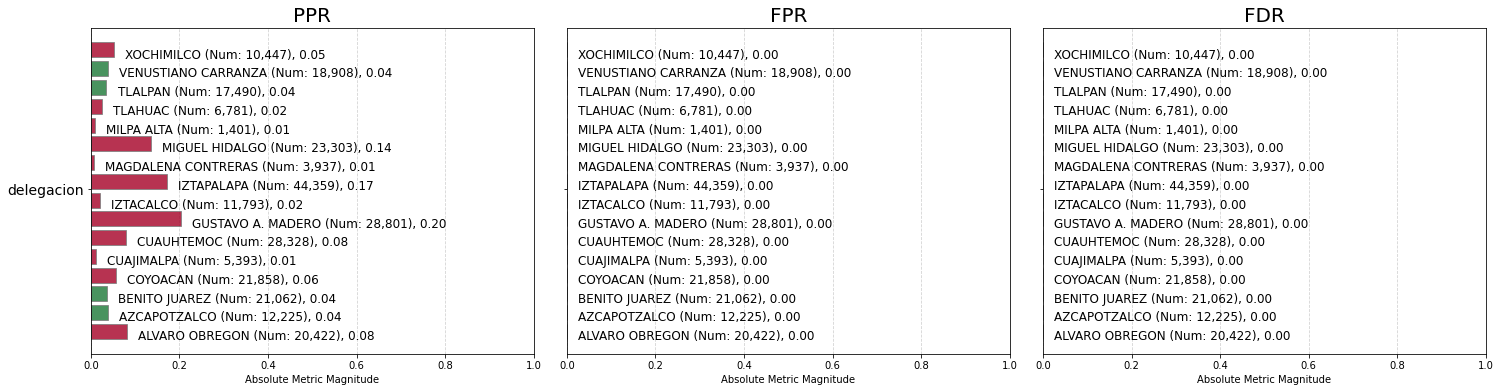

<Figure size 432x288 with 0 Axes>

In [156]:
z = aeq.plot_fairness_group_all(fdf, metrics=['ppr','fpr','fdr'])

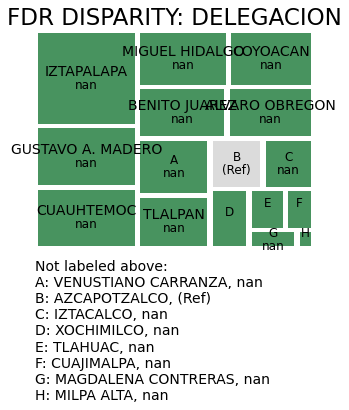

In [158]:
m = aeq.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='delegacion')

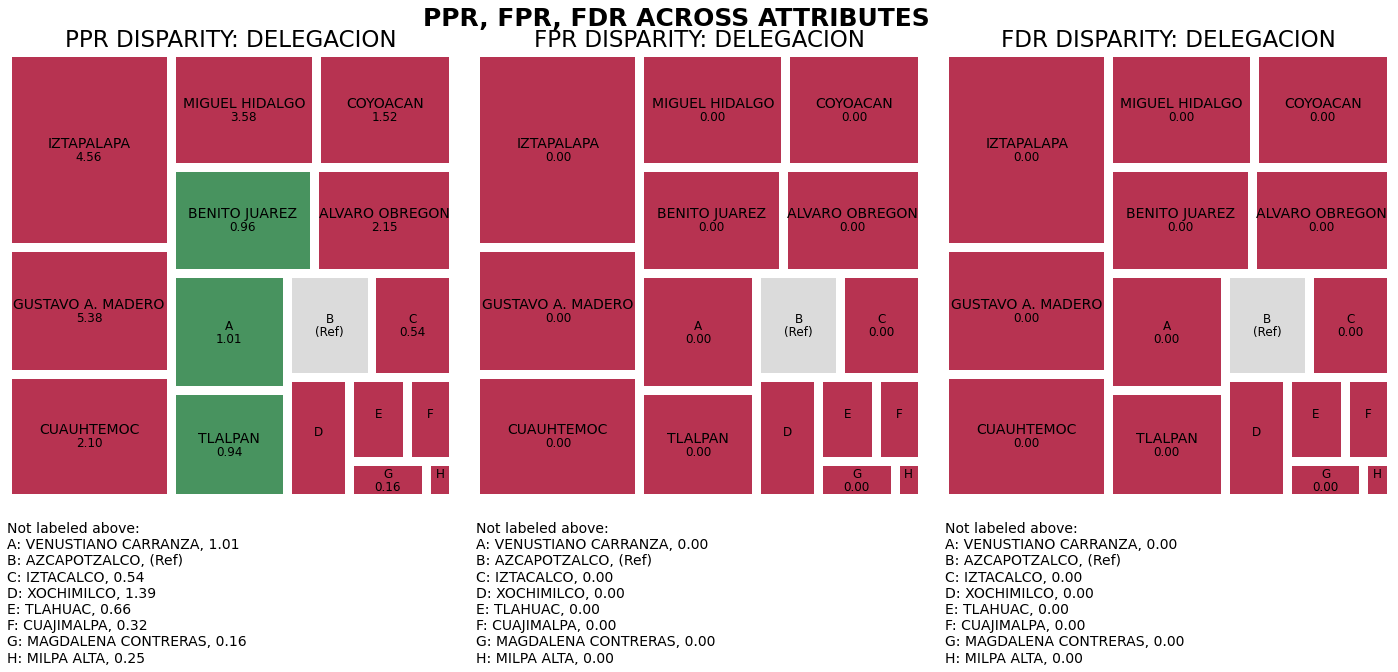

In [159]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])